In [1]:
from importLib import import_from_github, import_from_github_using_path
# imported tutorial
import_from_github(r"https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/extras/exercises/03_pytorch_computer_vision_exercises.ipynb")
import_from_github("https://raw.githubusercontent.com/GGisMee/PyLibraries/main/ml_toolkit/ml_funcs.py")
import_from_github('https://raw.githubusercontent.com/GGisMee/PyLibraries/main/ml_toolkit/helper_functions.py')
# libraries
import torch as pt
print(f"PyTorch version: {pt.__version__}")

device = 'cuda' if pt.cuda.is_available() else 'cpu'

import ml_funcs as mlf
import torchmetrics as tm
import torchvision as tv


c:/Users/22gusgam/Desktop/k/PyTorch/03/exercises/03_pytorch_computer_vision_exercises.ipynb already exists
c:/Users/22gusgam/Desktop/k/PyTorch/03/exercises/ml_funcs.py already exists
c:/Users/22gusgam/Desktop/k/PyTorch/03/exercises/helper_functions.py already exists
PyTorch version: 2.0.1+cu118


C:\Users\22gusgam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


##### QNA

What are 3 areas in industry where computer vision is currently being used?
1. Tesla autopilot
2. Face recogition
3. herbs and plants recognition (i.e telling which the name of plants from photos)

Search "what is overfitting in machine learning" and write down a sentence about what you find. 
* It is when the module is to fitted on the current data and therefore doesn't react and produce reliable results on new data

Search "ways to prevent overfitting in machine learning", write down 3 of the things you find and a sentence about each
1. Decrease the Model Complexity
2. Data Augmentation
    - Technique of artificially increasing the training set by creating modified copies of a dataset using existing data
3. Weight Regularization
    - Technique in which slight modifications are made to the learning algorithm which in its turn makes the model generalize better

### Load dataset Fer2013

In [2]:
import torchvision as tv
from torchvision.transforms import ToTensor
import os
train_data = tv.datasets.MNIST(root=f"{os.getcwd()}/data",
                               train=True, 
                               transform=ToTensor(), 
                               target_transform=None,
                               download=True
                               )

test_data = tv.datasets.MNIST(root=f"{os.getcwd()}/data",
                              train=False, 
                              transform=ToTensor(), 
                              target_transform=None,
                              download=True)

import matplotlib.pyplot as plt
import torchmetrics as tm


In [3]:
print(len(train_data), len(test_data))

60000 10000


### Visualize data

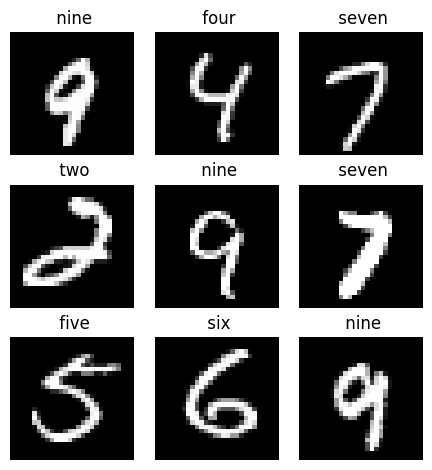

In [4]:
nrows = 3
ncols = 3
nprod = nrows*ncols
import random
seed = True
random.seed(42) if seed else None



for i in range(nprod):
    random_index = random.randint(0,len(train_data.targets))
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(train_data.data[random_index].squeeze(0), cmap="gray")
    plt.axis(False)
    plt.title(test_data.classes[train_data.targets[random_index]][3:]) 

plt.tight_layout(h_pad=0.5,w_pad=-10)
plt.show()
        



### Turn MNIST to dataloaders

In [5]:
from torch.utils.data import DataLoader
pt.manual_seed(42)
pt.cuda.manual_seed(42)
test_dataloader = DataLoader(dataset=train_data, batch_size=32,shuffle=False)
train_dataloader = DataLoader(dataset=test_data, batch_size=32,shuffle=True)

In [6]:
train_features_batch, training_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, training_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

### Create Model

In [7]:
from torch import nn
class MNIST_Model_V0(nn.Module):
    def __init__(self, input_shape:int, output_shape:int, hidden_units:int=10):
        super().__init__()
        self.conv_kernal_size = 3
        self.conv_stride = 1
        self.conv_padding = 1
        self.MaxPool_kernal_size = 2

        self.output_shape = output_shape
        self.hidden_units = hidden_units

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(input_shape,hidden_units, 
                      kernel_size=self.conv_kernal_size,stride=self.conv_stride, padding=self.conv_padding),
            nn.ReLU(),

            nn.Conv2d(hidden_units, hidden_units,
                      kernel_size=self.conv_kernal_size, stride=self.conv_stride, padding=self.conv_padding),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=self.MaxPool_kernal_size)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units,
                      kernel_size=self.conv_kernal_size, stride=self.conv_stride, padding=self.conv_padding),
            nn.ReLU(),

            nn.Conv2d(hidden_units, hidden_units,
                      kernel_size=self.conv_kernal_size, stride=self.conv_stride, padding=self.conv_padding),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=self.MaxPool_kernal_size)
        )
    def forward(self,X:pt.Tensor) -> pt.Tensor:
        X_change = self.conv_block_1(X)
        X_change = self.conv_block_2(X_change)
        #print(f"Original: {X_change.shape}")
        new_hidden_units = (pt.tensor(X_change.shape)[1:].prod().item())
        #print(f"New hidden units: {new_hidden_units}")
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(new_hidden_units,self.output_shape)
        )
        return self.classifier(X_change)

In [8]:
model0 = MNIST_Model_V0(input_shape=1, output_shape=len(train_data.classes), hidden_units=10).to(device)
model0

MNIST_Model_V0(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)

### Test using random Tensor

In [9]:
rand_tensor = pt.rand((1,28,28))
model0(rand_tensor)

tensor([[ 0.0268, -0.0517, -0.0658,  0.1360, -0.0435,  0.0482, -0.0251,  0.0862,
          0.0426,  0.0905],
        [ 0.0344, -0.0594, -0.0656,  0.1347, -0.0363,  0.0359, -0.0121,  0.0911,
          0.0491,  0.0893],
        [ 0.0556, -0.0939, -0.0633,  0.1322, -0.0127,  0.0078,  0.0215,  0.1067,
          0.0741,  0.0859],
        [ 0.0275, -0.0529, -0.0644,  0.1378, -0.0435,  0.0477, -0.0274,  0.0855,
          0.0440,  0.0882],
        [ 0.0739, -0.1185, -0.0621,  0.1364,  0.0124, -0.0112,  0.0454,  0.1210,
          0.0992,  0.0836],
        [ 0.0268, -0.0517, -0.0658,  0.1360, -0.0435,  0.0482, -0.0251,  0.0862,
          0.0426,  0.0905],
        [ 0.0345, -0.0671, -0.0565,  0.1387, -0.0279,  0.0331, -0.0096,  0.0876,
          0.0571,  0.0807],
        [ 0.0268, -0.0517, -0.0658,  0.1360, -0.0435,  0.0482, -0.0251,  0.0862,
          0.0426,  0.0905],
        [ 0.0268, -0.0517, -0.0658,  0.1360, -0.0435,  0.0482, -0.0251,  0.0862,
          0.0426,  0.0905],
        [ 0.0547, -

### Setup optimizer, loss function and accuracy function 

In [10]:

optimizer = pt.optim.SGD(params=model0.parameters(), lr=0.1)

accuracy_fn = tm.Accuracy('multiclass',num_classes=len(train_data.classes))

loss_fn = nn.CrossEntropyLoss()

### Train model 

In [11]:
from helper_functions import set_seeds
from timeit import default_timer as timer
from tqdm.auto import tqdm
start = timer()
set_seeds(42)
epochs = 5

for epoch in tqdm(range(epochs), desc="Epoch loops"):
    print(f"Epoch: {epoch}\n----------")
    mlf.Model_operations.train_step(model0, train_dataloader, optimizer, loss_fn, accuracy_fn, device,show=True)
    mlf.Model_operations.test_step(model0, test_dataloader, loss_fn, accuracy_fn, device,show=True)


time = mlf.time_func(start, device)

Epoch loops:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
----------
train loss: 2.303314447402954, train accuracy: 0.09874201565980911
Test loss: 2.3030, Test acc: 0.0996
Epoch: 1
----------
train loss: 2.3030121326446533, train accuracy: 0.09854233264923096
Test loss: 2.3028, Test acc: 0.1007
Epoch: 2
----------
train loss: 2.302891254425049, train accuracy: 0.09704472869634628
Test loss: 2.3030, Test acc: 0.0984

Train time on cpu: 84.611 seconds


In [12]:
mlf.Model_operations.eval_model(model0, test_dataloader, loss_fn, accuracy_fn, device)

{'model_name': 'MNIST_Model_V0',
 'model_loss': 2.3030247688293457,
 'model_acc': tensor(0.0991)}